<a href="https://colab.research.google.com/github/gav-ip/cse176-fall-proj/blob/part2-LeNet5/xgboost_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**XG Boost**
Change runtime type to T4 GPU

In [ ]:
# run this if on local local machine
# skip if on google colab
%pip install -r ../requirements.txt

In [13]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.io import loadmat
import seaborn as sns
import numpy as np
import pandas as pd
import xgboost as xgb

#**LOAD MNIST**

In [4]:
mnist = loadmat('./MNIST.mat')

# Extract data
X_train_full = mnist['train_fea']
y_train_full = mnist['train_gnd'].ravel()
X_test = mnist['test_fea']
y_test = mnist['test_gnd'].ravel()

# Split training into train and validation (55k train, 5k val)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=5000, random_state=42)

# shift labels to 0-9
y_train = y_train - 1
y_val = y_val - 1
y_test = y_test - 1

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")


Training set: (55000, 784), (55000,)
Validation set: (5000, 784), (5000,)
Test set: (10000, 784), (10000,)


#**MODEL FITTING AND EARLY STOPPING**
*- ran on Google Colab T4 GPU*

In [8]:
# Early stopping callback to prevent overfitting
early_stop = xgb.callback.EarlyStopping(
    rounds=20,
    metric_name='mlogloss',
    data_name='validation_0',
    save_best=True,
    min_delta=1e-3    # (default 1e-2) Improvement threshold for continued training, decreasing to prevent premature stopping or increase to mitigate overfitting
)
# Use "hist" for constructing the trees, with early stopping enabled.
clf = xgb.XGBClassifier(
    tree_method="hist",
    n_estimators=2000,
    eval_metric="mlogloss",
    device = 'cuda',
    learning_rate = 0.2,
    max_depth = 6,   # Balanced value of ranges of max_depth of the decision tree to prevent overfitting
    callbacks=[early_stop]
)

## Fitting model
(may take a couple minute to run)

In [9]:
# Fitting model using train and validation sets
clf.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=False  # Set to True if you want to see the log stream for training (validation_0) and validation (validation_1)
)

results = clf.evals_result()

epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)
print("done fitting")

done fitting


#**Performance Analysis**

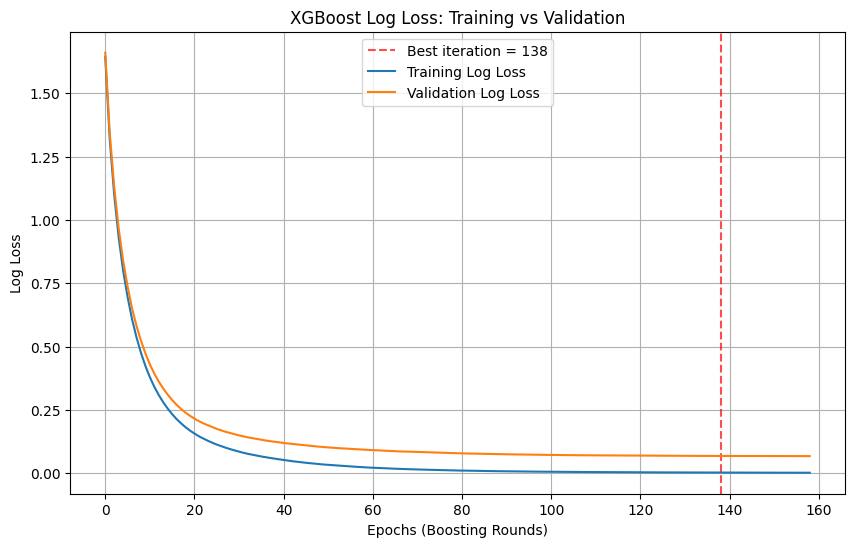

Best model found at iteration: 138
Test Accuracy (using best model): 0.9792


In [10]:
plt.figure(figsize=(10, 6))

plt.axvline(x=clf.best_iteration, color='r', linestyle='--', alpha=0.7, label=f'Best iteration = {clf.best_iteration}')

plt.plot(x_axis, results['validation_0']['mlogloss'], label='Training Log Loss')
plt.plot(x_axis, results['validation_1']['mlogloss'], label='Validation Log Loss')
plt.legend()
plt.xlabel('Epochs (Boosting Rounds)')
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss: Training vs Validation')
plt.grid(True)
plt.show()

print(f"Best model found at iteration: {clf.best_iteration}")

# This automatically uses the best iteration
y_test_pred = clf.predict(X_test)

# Calculate test accuracy
test_acc = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy (using best model): {test_acc:.4f}")

#**Generate confusion matrix**
evaluating on the test set

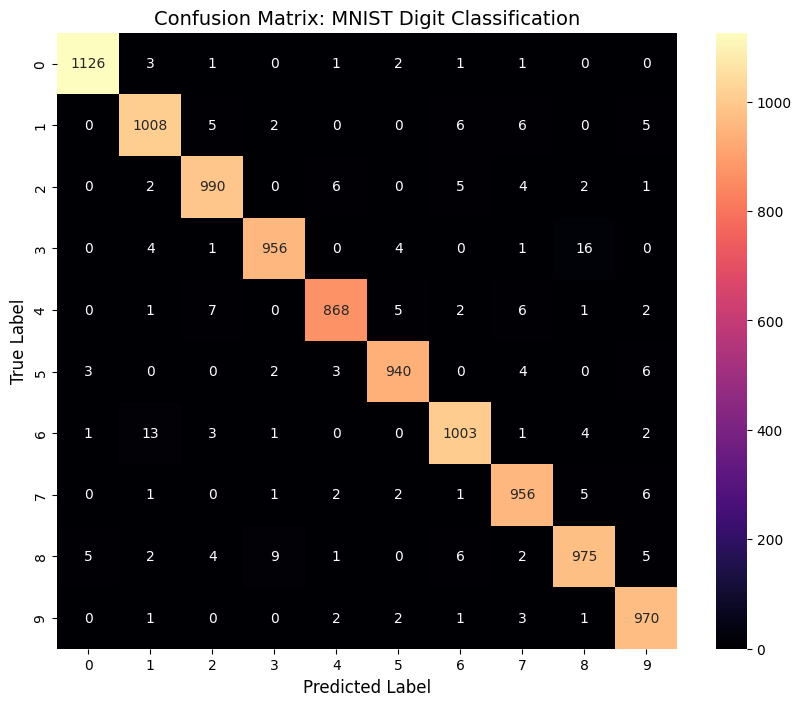


Classification Report:

              precision    recall  f1-score   support

           0     0.9921    0.9921    0.9921      1135
           1     0.9739    0.9767    0.9753      1032
           2     0.9792    0.9802    0.9797      1010
           3     0.9846    0.9735    0.9790       982
           4     0.9830    0.9731    0.9780       892
           5     0.9843    0.9812    0.9827       958
           6     0.9785    0.9757    0.9771      1028
           7     0.9715    0.9815    0.9765       974
           8     0.9711    0.9663    0.9687      1009
           9     0.9729    0.9898    0.9813       980

    accuracy                         0.9792     10000
   macro avg     0.9791    0.9790    0.9790     10000
weighted avg     0.9792    0.9792    0.9792     10000



In [11]:
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
            cm,
            cmap="magma",
            annot=True,
            fmt="d",
            cbar=True,
        )
plt.title('Confusion Matrix: MNIST Digit Classification', fontsize=14)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_test, y_test_pred, digits=4))

#**Load LeNet5**

In [14]:
LeNet = loadmat('./MNIST-LeNet5.mat')

print("Keys in .mat file: ", LeNet.keys())

# Extract data
X_train_full = LeNet['train_fea']
y_train_full = LeNet['train_gnd'].ravel()
X_test = LeNet['test_fea']
y_test = LeNet['test_gnd'].ravel()

# Split training into train and validation (55k train, 5k val)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=5000, random_state=42)

# shift labels to 0-9
y_train = y_train - 1
y_val = y_val - 1
y_test = y_test - 1

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

Keys in .mat file:  dict_keys(['__header__', '__version__', '__globals__', 'test_fea', 'test_gnd', 'train_fea', 'train_gnd'])
Training set: (55000, 800), (55000,)
Validation set: (5000, 800), (5000,)
Test set: (10000, 800), (10000,)


#**MODEL FITTING AND EARLY STOPPING**

In [17]:
# Early stopping callback to prevent overfitting
early_stop = xgb.callback.EarlyStopping(
    rounds=20,
    metric_name='mlogloss',
    data_name='validation_0',
    save_best=True,
    min_delta=1e-3    # (default 1e-2) Improvement threshold for continued training, decreasing to prevent premature stopping or increase to mitigate overfitting
)

# Use "hist" for constructing the trees, with early stopping enabled.
clf = xgb.XGBClassifier(
    tree_method="hist",
    n_estimators=2000,
    eval_metric="mlogloss",
    learning_rate = 0.2,
    device = 'cuda',
    max_depth = 6,   # Balanced value of ranges of max_depth of the decision tree to prevent overfitting
    callbacks=[early_stop]
)

#Fitting Model

In [18]:
# Fitting model using train and validation sets
clf.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=False  # Set to True if you want to see the log stream for training (validation_0) and validation (validation_1)
)

results = clf.evals_result()

epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)
print("done fitting")

done fitting


#**Performance Analysis**

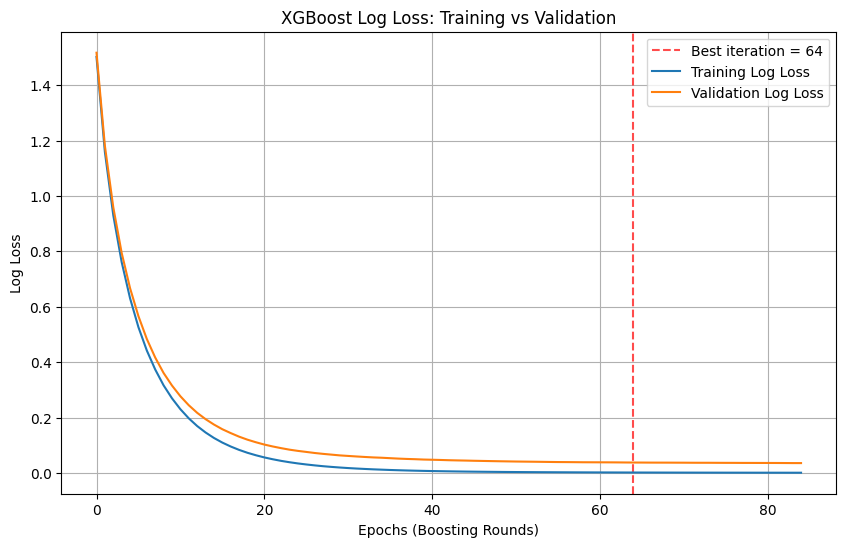

Best model found at iteration: 64
Test Accuracy (using best model): 0.9875


In [19]:
plt.figure(figsize=(10, 6))

plt.axvline(x=clf.best_iteration, color='r', linestyle='--', alpha=0.7, label=f'Best iteration = {clf.best_iteration}')

plt.plot(x_axis, results['validation_0']['mlogloss'], label='Training Log Loss')
plt.plot(x_axis, results['validation_1']['mlogloss'], label='Validation Log Loss')
plt.legend()
plt.xlabel('Epochs (Boosting Rounds)')
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss: Training vs Validation')
plt.grid(True)
plt.show()

print(f"Best model found at iteration: {clf.best_iteration}")

# This automatically uses the best iteration
y_test_pred = clf.predict(X_test)

# Calculate test accuracy
test_acc = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy (using best model): {test_acc:.4f}")

#**Generate confusion matrix**


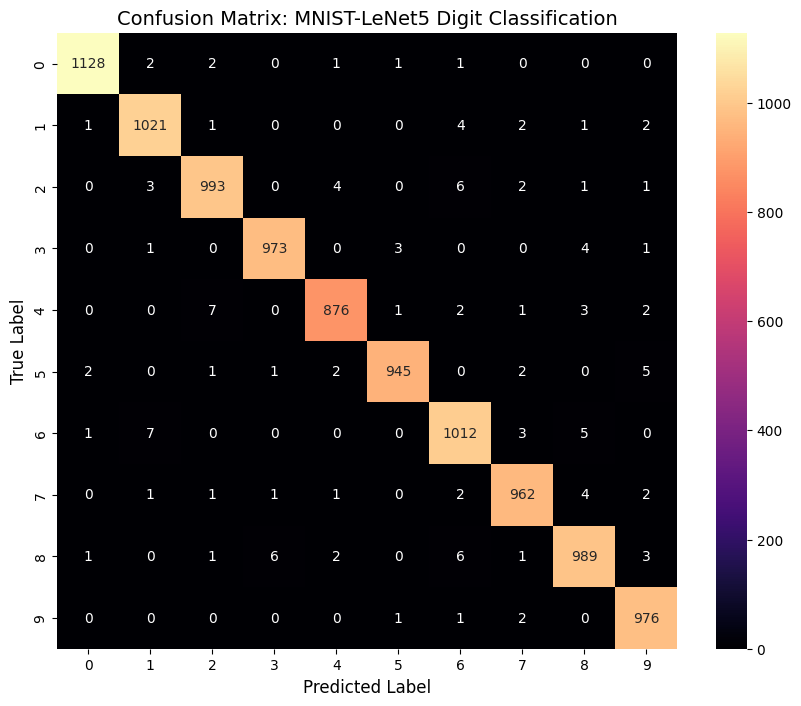


Classification Report:

              precision    recall  f1-score   support

           0     0.9956    0.9938    0.9947      1135
           1     0.9865    0.9893    0.9879      1032
           2     0.9871    0.9832    0.9851      1010
           3     0.9918    0.9908    0.9913       982
           4     0.9887    0.9821    0.9854       892
           5     0.9937    0.9864    0.9900       958
           6     0.9787    0.9844    0.9816      1028
           7     0.9867    0.9877    0.9872       974
           8     0.9821    0.9802    0.9812      1009
           9     0.9839    0.9959    0.9899       980

    accuracy                         0.9875     10000
   macro avg     0.9875    0.9874    0.9874     10000
weighted avg     0.9875    0.9875    0.9875     10000



In [21]:
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
            cm,
            cmap="magma",
            annot=True,
            fmt="d",
            cbar=True,
        )
plt.title('Confusion Matrix: MNIST-LeNet5 Digit Classification', fontsize=14)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_test, y_test_pred, digits=4))